# Import Packages

In [2]:
# Numerical Operations
import numpy as np
import math
from matplotlib import pyplot as plt

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
import torchvision.transforms as transforms

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

# Useful Functions

In [3]:
def same_seed(seed): 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def predict(test_loader, model, device):
    model.eval()
    preds_list = list()
    labels_list = list()
    for imgs, labels in tqdm(test_loader):
        imgs = imgs.to(device)
        labels_list += labels.squeeze().tolist()                       
        with torch.no_grad():  
            pred = model(imgs) 
            pred_label = np.argmax(pred.cpu().data.numpy(), axis=1)
            preds_list += pred_label.squeeze().tolist()          
    return preds_list, labels_list


def save_pred(preds, file):
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'pred'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

def cal_l2(model):
    l2_weight = 0.1
    l2_parameters = list()
    for parameter in model.parameters():
        l2_parameters.append(parameter.view(-1))
        l2 = l2_weight * model.compute_l2_loss(torch.cat(l2_parameters))
    return l2

# Datasets

In [4]:
train_tfm = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

CIFAR_train = datasets.CIFAR10('./CIFAR10_training', train=True, download=False, transform=train_tfm)
CIFAR_test = datasets.CIFAR10('./CIFAR10_testing', train=False, download=False, transform=test_tfm)
train_set, valid_set = torch.utils.data.random_split(CIFAR_train, [45000, 5000])
test_set = CIFAR_test

RuntimeError: Dataset not found or corrupted. You can use download=True to download it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])
1


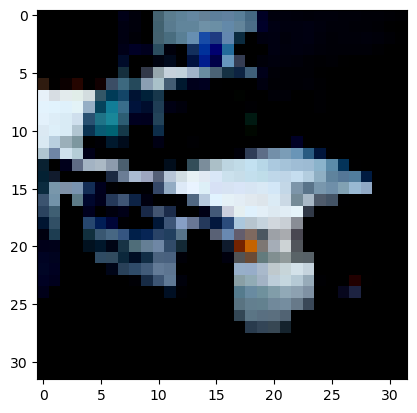

In [5]:
img, label = train_set[0]
print(img.shape)
print(label)
plt.imshow(img.permute(1,2,0))
plt.show()

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Configurations

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    'seed':6666,
    'n_epochs': 100,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-4,              
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

# DataLoder

In [7]:
train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=config['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

# Module

In [19]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input dim [3, 32, 32]
        self.cnn_layers = nn.Sequential(

            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.AvgPool2d(kernel_size=1,stride=1),
            )


        self.fc_layers = nn.Sequential(
            
            nn.Linear(512,4096),
            nn.ReLU(True),
            nn.Dropout(),
            
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
    
            nn.Linear(4096, 10),

        )

    def forward(self, x):
        out = self.cnn_layers(x)
        out = out.view(out.size()[0], -1)
        return self.fc_layers(out)


    def compute_l2_loss(self, w):
        return torch.square(w).sum()

# Training Loop

In [25]:
def trainer(train_loader, valid_loader, test_loader, model, config, device):

    criterion = nn.CrossEntropyLoss() 
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])


    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set model to train mode.
        train_loss = []
        train_accs = []

        train_pbar = tqdm(train_loader, position=0, leave=True)

        for imgs, labels in train_pbar:
            
            imgs, labels = imgs.to(device), labels.to(device)   # Move your data to device. 
            pred = model(imgs)  

            loss = criterion(pred, labels)
            l2 = cal_l2(model)
            loss += l2

            acc = (pred.argmax(dim=-1) == labels.to(device)).float().mean()
            optimizer.zero_grad()               # Set gradient to zero.
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            
            train_loss.append(loss.detach().item())
            train_accs.append(acc)
            
            step += 1
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(train_loss) / len(train_loss)
        mean_train_acc = sum(train_accs) / len(train_accs)


        model.eval() # Set your model to evaluation mode.
        valid_loss = []
        valid_accs = []
        test_loss = []
        test_accs = []

        for imgs, labels in valid_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                pred = model(imgs)
                loss = criterion(pred, labels)
                l2 = cal_l2(model)
                loss += l2
                acc = (pred.argmax(dim=-1) == labels.to(device)).float().mean()

            valid_loss.append(loss.item())
            valid_accs.append(acc)
            
        mean_valid_loss = sum(valid_loss) / len(valid_loss)
        mean_valid_acc = sum(valid_accs) / len(valid_accs)
        
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')


        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                pred = model(imgs)
                loss = criterion(pred, labels)
                l2 = cal_l2(model)
                loss += l2
                acc = (pred.argmax(dim=-1) == labels.to(device)).float().mean()

            test_loss.append(loss.item())
            test_accs.append(acc)

        mean_test_loss = sum(test_loss) / len(test_loss)
        mean_test_acc = sum(test_accs) / len(test_accs)


        writer.add_scalars('Loss', {'train':mean_train_loss, 'valid':mean_valid_loss, 'test':mean_test_loss}, step)
        writer.add_scalars('Accuracy', {'train':mean_train_acc, 'valid':mean_valid_acc, 'test':mean_test_acc}, step)


        for name, parms in model.named_parameters():
            writer.add_histogram(name, parms, step)



        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return
        

# Start training

In [26]:
same_seed(config['seed'])

model = Classifier().to(device)
trainer(train_loader, valid_loader, test_loader, model, config, device)

Epoch [1/30]: 100%|██████████| 176/176 [00:13<00:00, 12.93it/s, loss=295]


Epoch [1/30]: Train loss: 376.9547, Valid loss: 294.3215
Saving model with loss 294.322...


Epoch [2/30]: 100%|██████████| 176/176 [00:13<00:00, 13.10it/s, loss=197]


Epoch [2/30]: Train loss: 243.3640, Valid loss: 196.7134
Saving model with loss 196.713...


Epoch [3/30]: 100%|██████████| 176/176 [00:13<00:00, 13.06it/s, loss=127]


Epoch [3/30]: Train loss: 159.8406, Valid loss: 126.4107
Saving model with loss 126.411...


Epoch [4/30]: 100%|██████████| 176/176 [00:13<00:00, 13.07it/s, loss=77.4]


Epoch [4/30]: Train loss: 100.5764, Valid loss: 77.3884
Saving model with loss 77.388...


Epoch [5/30]: 100%|██████████| 176/176 [00:13<00:00, 13.07it/s, loss=45.5]


Epoch [5/30]: Train loss: 60.7598, Valid loss: 45.6561
Saving model with loss 45.656...


Epoch [6/30]: 100%|██████████| 176/176 [00:13<00:00, 13.05it/s, loss=25.6]


Epoch [6/30]: Train loss: 35.2033, Valid loss: 25.6499
Saving model with loss 25.650...


Epoch [7/30]: 100%|██████████| 176/176 [00:13<00:00, 13.08it/s, loss=14.1]


Epoch [7/30]: Train loss: 19.5838, Valid loss: 14.2943
Saving model with loss 14.294...


Epoch [8/30]: 100%|██████████| 176/176 [00:13<00:00, 13.13it/s, loss=7.97]


Epoch [8/30]: Train loss: 11.2437, Valid loss: 8.1266
Saving model with loss 8.127...


Epoch [9/30]: 100%|██████████| 176/176 [00:13<00:00, 13.07it/s, loss=5.09]


Epoch [9/30]: Train loss: 6.3767, Valid loss: 5.0001
Saving model with loss 5.000...


Epoch [10/30]: 100%|██████████| 176/176 [00:13<00:00, 13.15it/s, loss=3.14]


Epoch [10/30]: Train loss: 3.8703, Valid loss: 3.1392
Saving model with loss 3.139...


Epoch [11/30]: 100%|██████████| 176/176 [00:13<00:00, 13.04it/s, loss=2.59]


Epoch [11/30]: Train loss: 2.8193, Valid loss: 2.5850
Saving model with loss 2.585...


Epoch [12/30]: 100%|██████████| 176/176 [00:13<00:00, 13.18it/s, loss=2.39]


Epoch [12/30]: Train loss: 2.4689, Valid loss: 2.3872
Saving model with loss 2.387...


Epoch [13/30]: 100%|██████████| 176/176 [00:13<00:00, 13.18it/s, loss=2.33]


Epoch [13/30]: Train loss: 2.3500, Valid loss: 2.3249
Saving model with loss 2.325...


Epoch [14/30]: 100%|██████████| 176/176 [00:13<00:00, 13.19it/s, loss=2.31]


Epoch [14/30]: Train loss: 2.3145, Valid loss: 2.3078
Saving model with loss 2.308...


Epoch [15/30]: 100%|██████████| 176/176 [00:13<00:00, 13.28it/s, loss=2.3] 


Epoch [15/30]: Train loss: 2.3053, Valid loss: 2.3038
Saving model with loss 2.304...


Epoch [16/30]: 100%|██████████| 176/176 [00:13<00:00, 13.18it/s, loss=2.3]


Epoch [16/30]: Train loss: 2.3032, Valid loss: 2.3030
Saving model with loss 2.303...


Epoch [17/30]: 100%|██████████| 176/176 [00:13<00:00, 13.18it/s, loss=2.3]


Epoch [17/30]: Train loss: 2.3028, Valid loss: 2.3028
Saving model with loss 2.303...


Epoch [18/30]: 100%|██████████| 176/176 [00:13<00:00, 13.14it/s, loss=2.3]


Epoch [18/30]: Train loss: 2.3028, Valid loss: 2.3028
Saving model with loss 2.303...


Epoch [19/30]: 100%|██████████| 176/176 [00:13<00:00, 13.18it/s, loss=2.3]


Epoch [19/30]: Train loss: 2.3028, Valid loss: 2.3027
Saving model with loss 2.303...


Epoch [20/30]: 100%|██████████| 176/176 [00:13<00:00, 13.30it/s, loss=2.3]


Epoch [20/30]: Train loss: 2.3028, Valid loss: 2.3027


Epoch [21/30]: 100%|██████████| 176/176 [00:13<00:00, 13.28it/s, loss=2.3]


Epoch [21/30]: Train loss: 2.3028, Valid loss: 2.3028


Epoch [22/30]: 100%|██████████| 176/176 [00:13<00:00, 13.32it/s, loss=2.3]


Epoch [22/30]: Train loss: 2.3029, Valid loss: 2.3028


Epoch [23/30]: 100%|██████████| 176/176 [00:13<00:00, 13.04it/s, loss=2.3]


Epoch [23/30]: Train loss: 2.3029, Valid loss: 2.3028


Epoch [24/30]: 100%|██████████| 176/176 [00:20<00:00,  8.54it/s, loss=2.3]


Epoch [24/30]: Train loss: 2.3029, Valid loss: 2.3029


Epoch [25/30]: 100%|██████████| 176/176 [00:20<00:00,  8.44it/s, loss=2.3]


Epoch [25/30]: Train loss: 2.3029, Valid loss: 2.3029


Epoch [26/30]: 100%|██████████| 176/176 [00:20<00:00,  8.43it/s, loss=2.3]


Epoch [26/30]: Train loss: 2.3030, Valid loss: 2.3029


Epoch [27/30]: 100%|██████████| 176/176 [00:21<00:00,  8.38it/s, loss=2.3]


Epoch [27/30]: Train loss: 2.3030, Valid loss: 2.3030


Epoch [28/30]: 100%|██████████| 176/176 [00:16<00:00, 10.72it/s, loss=2.3]


Epoch [28/30]: Train loss: 2.3030, Valid loss: 2.3030


Epoch [29/30]: 100%|██████████| 176/176 [00:19<00:00,  8.84it/s, loss=2.3]


Epoch [29/30]: Train loss: 2.3031, Valid loss: 2.3031


Epoch [30/30]: 100%|██████████| 176/176 [00:14<00:00, 12.30it/s, loss=2.3]


Epoch [30/30]: Train loss: 2.3031, Valid loss: 2.3032


# Testing

In [11]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(config['save_path']))
preds_list, labels_list = predict(test_loader, model_best, device)  

save_pred(preds_list, 'preds_list.csv')
save_pred(labels_list, 'labels_list.csv')

100%|██████████| 40/40 [00:04<00:00,  9.60it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


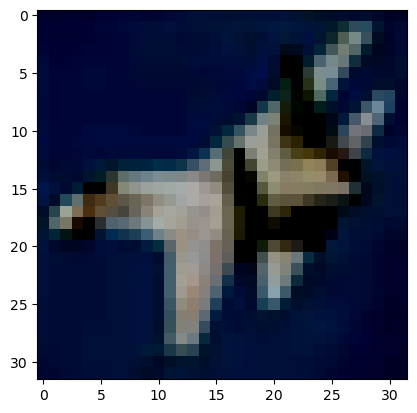

label: 0, pred: 4


In [15]:
img, label = test_set[10]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f'label: {label}, pred: {preds_list[10]}')

# Hook

In [13]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(config['save_path']))
model_best.eval()

record_conv0 = list()
record_conv1 = list()
record_conv2 = list()


def hook_conv0(self, input, output):
    record_conv0.append(output)

def hook_conv1(self, input, output):
    record_conv1.append(output)

def hook_conv2(self, input, output):
    record_conv2.append(output)


model_best.cnn_layers[0].register_forward_hook(hook_conv0)
model_best.cnn_layers[3].register_forward_hook(hook_conv1)
model_best.cnn_layers[7].register_forward_hook(hook_conv2)


test_Img = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)


with torch.no_grad():
    for imgs, labels in test_Img:
        test_pred = model_best(imgs.to(device))

# Feature Map

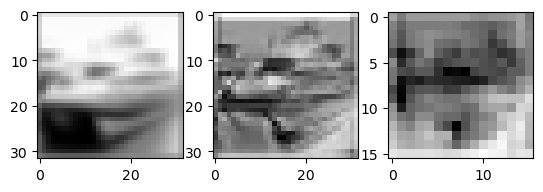

In [17]:
conv0_out = record_conv0[1].squeeze(0)
conv0_out = torch.mean(conv0_out, dim=0)
conv0_out = conv0_out.cpu()

conv1_out = record_conv1[1].squeeze(0)
conv1_out = torch.mean(conv1_out, dim=0)
conv1_out = conv1_out.cpu()

conv2_out = record_conv2[1].squeeze(0)
conv2_out = torch.mean(conv2_out, dim=0)
conv2_out = conv2_out.cpu()

plt.subplot(1,3,1)
plt.imshow(conv0_out, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(conv1_out, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(conv2_out, cmap='gray')
plt.show()